In [3]:
import os
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings

load_dotenv()
# Load the API key from the .env file
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [2]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient

client = QdrantClient("http://qdrant.homehub.tv")
vector_store = QdrantVectorStore(
    client=client,
    collection_name="obsidian_docs",
    embedding=embeddings,
)

# Check if collection exists
if not client.collection_exists("obsidian_docs"):
    raise ValueError("Collection 'obsidian_docs' does not exist")

In [5]:
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}


# Build graph
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

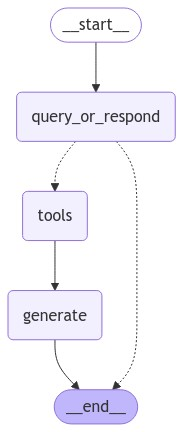

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [9]:
input_message = "What is the knowledge crisis"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the knowledge crisis
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_tl9B7POL5UrMoyviJJC9ykAO)
 Call ID: call_tl9B7POL5UrMoyviJJC9ykAO
  Args:
    query: knowledge crisis
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'Living Knowledge Management.md', 'path': 'data/Knowledge/Theories/Living Knowledge Management.md', 'created': 1734100893.9219086, 'last_modified': 1734100893.9219086, 'last_accessed': 1735241800.4131176, 'title': 'A Unified Theory of Living Knowledge Management', 'date created': '2024-12-12', 'date modified': '2024-12-13', '_id': 'b74f1de4-97f1-46c5-ba7b-bdb2eb85390d', '_collection_name': 'obsidian_docs'}
Content: # A Unified Theory of Living Knowledge Management

## The Crisis and Solution

The modern knowledge crisis stems from two fundamental problems

In [10]:
input_message = "Can you look up some common ways of solving it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of solving it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_bTYwptVU1u2syjWX99KWy6WD)
 Call ID: call_bTYwptVU1u2syjWX99KWy6WD
  Args:
    query: solutions to knowledge crisis
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'Living Knowledge Management.md', 'path': 'data/Knowledge/Theories/Living Knowledge Management.md', 'created': 1734100893.9219086, 'last_modified': 1734100893.9219086, 'last_accessed': 1735241800.4131176, 'title': 'A Unified Theory of Living Knowledge Management', 'date created': '2024-12-12', 'date modified': '2024-12-13', '_id': 'b74f1de4-97f1-46c5-ba7b-bdb2eb85390d', '_collection_name': 'obsidian_docs'}
Content: # A Unified Theory of Living Knowledge Management

## The Crisis and Solution

The modern knowledge crisis ste

In [11]:
chat_history = graph.get_state(config).values["messages"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

What is the knowledge crisis
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_tl9B7POL5UrMoyviJJC9ykAO)
 Call ID: call_tl9B7POL5UrMoyviJJC9ykAO
  Args:
    query: knowledge crisis
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'Living Knowledge Management.md', 'path': 'data/Knowledge/Theories/Living Knowledge Management.md', 'created': 1734100893.9219086, 'last_modified': 1734100893.9219086, 'last_accessed': 1735241800.4131176, 'title': 'A Unified Theory of Living Knowledge Management', 'date created': '2024-12-12', 'date modified': '2024-12-13', '_id': 'b74f1de4-97f1-46c5-ba7b-bdb2eb85390d', '_collection_name': 'obsidian_docs'}
Content: # A Unified Theory of Living Knowledge Management

## The Crisis and Solution

The modern knowledge crisis stems from two fundamental problems

In [12]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the knowledge crisis?\n\n"
    "Once you get the answer, look up potential tools to solve it."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()